# Introduction
We will use a Kalman filter to estimate the state mean $\mu_{t-1}$ and state variance $\sigma_{t-1}^2$ of industry returns at time $t - 1$. To do this, we will use data from $t - 24$ to $t - 1$. Using this information, we will construct a signal for investment at time $t$ of the form
$$
\mu_{t-1} - \frac{\gamma}{2}\sigma_{t-1}^2.
$$
We will suppose $\gamma = 1$ in our calculations. The data were obtained from the Ken French Data Library. We used equally weighted monthly industry returns. The date range is from July 1927 to November 2020.

# Packages and Setup

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statsmodels.api as sm
import os
os.chdir('/Users/charlesrambo/Desktop/GitHub data')

In [2]:
# Load equally weighted industry return data
industry = pd.read_csv('10_Industry_Portfolios.csv')

# Convert date column into date-time object
industry['Date'] = pd.to_datetime(industry['Date'], format = '%Y%m') + MonthEnd(0)

# Convert returns to a decimal 
industry.iloc[:, 1:] = industry.iloc[:, 1:].div(100)

industry.head()

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,1926-07-31,0.0116,0.0403,0.0230,-0.0219,0.0221,0.0131,0.0069,0.0245,0.0485,0.0021
1,1926-08-31,0.0500,0.0028,0.0211,0.0441,0.0261,0.0108,-0.0003,0.0611,-0.0200,0.0453
2,1926-09-30,0.0003,-0.0334,0.0053,-0.0351,0.0086,0.0022,-0.0071,0.0080,0.0206,-0.0053
3,1926-10-31,-0.0255,-0.0946,-0.0511,0.0267,-0.0572,-0.0099,-0.0328,0.0013,-0.0298,-0.0251
4,1926-11-30,0.0600,-0.0038,0.0169,0.0159,0.0132,0.0148,0.0135,0.0720,0.0571,0.0085


We will use the EM method of the Kalman filter object to estimate the the parameters of the Kalman filter.

In [3]:
# Create function to calculate Kalman momentum
def calc_kal_mom(data, window):

    # Record the number of variables; one fewer than the number of columns in data
    n = len(data.columns) - 1

    # Save identity matrix
    I = np.eye(n)

    # Create data frame to record signal values
    kal_mom = pd.DataFrame(index = data.index[window:], columns = data.columns)

    # Create filter
    kf = KalmanFilter(initial_state_mean = np.zeros(n),
                initial_state_covariance =  0.10**2 * I,
                transition_matrices = I,
                transition_covariance = I,
                observation_matrices = I,
                observation_covariance = 0.10**2 * I)

    # We will loop over the date
    dates = np.unique(data['Date'])[window:]

    for date in dates:
    
        # Obtain the end of the signal formation, exclusive
        stop = np.sum(data['Date'] < date)
    
        # Record the beginning of signal, inclusive
        start = stop - window
    
        # Get 'measurement' values for Kalman filter
        X = np.array(data.iloc[start:stop, 1:])
    
        try:
        
            kf = kf.em(X, n_iter = 5)
            mu, sigma = kf.smooth(X)
    
        except:
        
            # If det(X'X) is too small for Kalman filter, use 0 as state estimates
            mu, sigma = [np.zeros(n)], [np.zeros((n, n))]
    
        # Record date for later merger
        kal_mom.loc[stop, 'Date'] = date    
    
        # Record signal
        kal_mom.loc[stop, data.columns[1:]] = mu[-1] - 0.5 * np.diag(sigma[-1])
        
    # Convert data column to data-time object
    kal_mom['Date'] = pd.to_datetime(kal_mom['Date'])
    
    # Change structure of data frame so industries are observations
    kal_mom = pd.melt(kal_mom, id_vars = ['Date'], value_vars = kal_mom.columns[1:])

    # Change column names
    kal_mom.columns = ['Date', 'Industry', 'Kal_mom']
        
    return kal_mom

# Create the data frame for signal
kal_mom = calc_kal_mom(data = industry, window = 24)
    
kal_mom.head()

,Date,Industry,Kal_mom
0,1928-07-31,NoDur,-0.0421504
1,1928-08-31,NoDur,-0.0103538
2,1928-09-30,NoDur,0.0115828
3,1928-10-31,NoDur,0.0280554
4,1928-11-30,NoDur,0.0207193


In [4]:
# Create function that combines returns with signal and then implements strategy
def calc_strg_rtn(returns, signal, quants):

    # Change structure of data frame so industries are observations
    returns = pd.melt(returns, id_vars = ['Date'], value_vars = returns.columns[1:])

    # Change column names
    returns.columns = ['Date', 'Industry', 'Ret']
    
    # Perform merge
    df = returns.merge(signal, on = ['Date', 'Industry'])

    # Calculate quintiles
    df['Quintile'] = df[['Date', 'Kal_mom']].groupby('Date')['Kal_mom'].transform(lambda x: 
                                                                                  pd.qcut(x, quants, labels = False))

    # Add 1 to quintile to avoid confusion
    df['Quintile'] = 1 + df['Quintile']

    # Drop columns that have done their jobs
    df.drop(['Kal_mom', 'Industry'], axis = 1, inplace = True)
    
    # Calculate equally weighted returns for each quintile
    result = df.groupby(['Date', 'Quintile'])['Ret'].mean().reset_index()

    # Make each quintile its own column
    result = result.pivot(index = 'Date', columns = 'Quintile', values = 'Ret').reset_index()

    # Calculate winners minus losers
    result['WML'] = result[quants] - result[1]
    
    return result

# Create data frame for returns
result = calc_strg_rtn(returns = industry, signal = kal_mom, quants = 5)

result.head()

Quintile,Date,1,2,3,4,5,WML
0,1928-07-31,0.00175,0.00970,-0.00550,0.01075,-0.00320,-0.00495
1,1928-08-31,0.07455,0.06175,0.01655,0.07550,0.06585,-0.00870
2,1928-09-30,0.04025,0.02910,0.04085,0.07620,0.01610,-0.02415
3,1928-10-31,0.03770,0.01685,0.01115,0.02060,0.00895,-0.02875
4,1928-11-30,0.12655,0.16225,0.06200,0.10175,0.11665,-0.00990


# Results
We will annualize our returns under the assumption that they are independent and identically distributed. We will also ignore compounding effects. Under these assumptions, the conversions are as follows
\begin{align*}
    \mu_{\text{annual}} &\approx 12\times\mu_{\text{monthly}}\\
    \sigma_{\text{annual}} &\approx \sqrt{12}\times\sigma_{\text{monthly}}\\
    \mathcal{Sk}_{\text{annual}} &\approx 12\sqrt{12}\times \mathcal{Sk}_{\text{monthly}}.
\end{align*}
The annualization is only intended to give a sense of scale.

In [5]:
# Create function which gives return statistics
def get_rtn_stats(result):
    
    # Create data frame for return statistics
    stats = pd.DataFrame(index = result.columns[1:])

    # Take a look at the mean
    stats['mean'] = 12 * result.mean()

    # Take a look at the sd
    stats['sd'] = 12**(1/2) * result.std()

    # Take a look at the skew
    stats['skew'] = 12**(3/2) * result.skew()

    return stats

# Obtain return statistics for training set
get_rtn_stats(result)

,mean,sd,skew
Quintile,,,
1,0.074030,0.275406,43.836837
2,0.132332,0.258183,53.194914
3,0.139259,0.244602,37.827269
4,0.173895,0.247737,53.121848
5,0.221626,0.252093,40.614704
WML,0.147597,0.185299,-37.109804


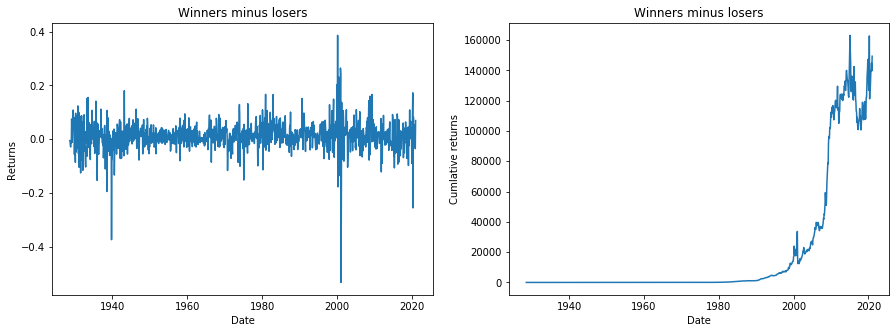

In [6]:
# Create function to plot results
def plot_result(result):

    # Plot returns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

    ax1.plot(result['Date'], result['WML'])
    ax1.set_xlabel('Date') 
    ax1.set_ylabel('Returns') 
    ax1.set_title('Winners minus losers') 

    ax2.plot(result['Date'], (1 + result['WML']).cumprod() - 1) 
    ax2.set_xlabel('Date') 
    ax2.set_ylabel('Cumlative returns') 
    ax2.set_title('Winners minus losers') 

    plt.show()
    
plot_result(result)

We will examine the factor loadings. Results are not annualized and both the explanatory and response variables are written in decimal form. The factors were obtained from the Ken French Data Library, and the time range is from January 1927 to December 2020.

In [15]:
# Load Fama French factors
FF = pd.read_csv('FF.csv')

# Convert date column into date-time object
FF['Date'] = pd.to_datetime(FF['Date'], format = '%m/%d/%y') + MonthEnd(0)

# Create convert date function
convert_date = lambda date: '19' + str(date)[2:]

# Fix bad dates
FF.loc[FF['Date'].dt.year > 2020, 'Date'] = FF.loc[FF['Date'].dt.year > 2020, 'Date'].apply(convert_date)

# Resave as date-time object
FF['Date'] = pd.to_datetime(FF['Date'], format = '%Y-%m-%d') + MonthEnd(0)

# Convert returns to a decimal
FF.iloc[:, 1:] = FF.iloc[:, 1:].div(100)

# Create function to get factor loadings
def get_factor_loadings(result, column, FF):
    
    # Merge data with Fama French factors
    data = result.merge(FF, on = 'Date')
    
    # Create numpy array of Fama French factors
    X = sm.add_constant(data[['Mkt-RF', 'SMB', 'HML', 'MOM']].values)
    
    # Create numpy array for response variable
    y = data[column].values
    
    output = sm.OLS(y, X)
    
    output = output.fit()
    
    print(output.summary(xname = ['alpha', 'Mkt-RF', 'SMB', 'HML', 'MOM'], yname = str(column)))
    

In [17]:
# Lowest quintile (short-end) factor loadings
get_factor_loadings(result, 1, FF)

                            OLS Regression Results                            
Dep. Variable:                      1   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     1376.
Date:                Sat, 27 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:33:26   Log-Likelihood:                 2228.7
No. Observations:                1110   AIC:                            -4447.
Df Residuals:                    1105   BIC:                            -4422.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0003      0.001      0.252      0.8

In [18]:
# Highest quintile (long-end) factor loadings
get_factor_loadings(result, 5, FF)

                            OLS Regression Results                            
Dep. Variable:                      5   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     1136.
Date:                Sat, 27 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:33:36   Log-Likelihood:                 2239.7
No. Observations:                1110   AIC:                            -4469.
Df Residuals:                    1105   BIC:                            -4444.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0088      0.001      8.763      0.0

In [19]:
# Long-short strategy factor loadings
get_factor_loadings(result, 'WML', FF)

                            OLS Regression Results                            
Dep. Variable:                    WML   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     52.12
Date:                Sat, 27 Feb 2021   Prob (F-statistic):           3.00e-40
Time:                        17:33:48   Log-Likelihood:                 1771.7
No. Observations:                1110   AIC:                            -3533.
Df Residuals:                    1105   BIC:                            -3508.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0085      0.002      5.582      0.0